In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import random, math, os, time

import numpy as np
np.set_printoptions(threshold=np.inf)
import pandas as pd

In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [0]:
# set the random seeds for reproducability
SEED = 1234
random.seed(SEED)


def generate_samples(x, y, model_params, seq_len_before=7, seq_len_after=7, output_seq_len=9):
    """
    Generate samples, input past and future, target middle
    :param x: input dataframe
    :param y: target variable to impute
    :param seq_len_before:
    :param seq_len_after:
    :param output_seq_len:
    :return: (inputsequence, targetsequence)
    """
    total_samples = x.shape[0]
    total_len = seq_len_before + seq_len_after + output_seq_len

    input_batch_idxs = [list(range(i, i + seq_len_before)) + list(
        range(i + seq_len_before + output_seq_len, i + seq_len_before + output_seq_len + seq_len_after)) for i in
                        range((total_samples - total_len + 1))]

    input_seq = np.take(x, input_batch_idxs, axis=0)

    z = np.zeros((output_seq_len, model_params['dim_in']))

    input_seq = np.array([np.concatenate((i[:seq_len_before], z, i[seq_len_before:])) for i in input_seq])

    output_batch_idxs = [list(range(i + seq_len_before, i + seq_len_before + output_seq_len)) for i in
                         range((total_samples - total_len + 1))]

    output_seq = np.take(y, output_batch_idxs, axis=0)

    return input_seq, output_seq


def pad_all_cases(x, y, model_params, min_len_before=7, max_len_before=9, min_len_after=7, max_len_after=9,
                  targetlength=9):
    """
    variable length inputs, fix length outputs
    :param x: input dataframe
    :param y: target variable to impute
    :param min_len_before:
    :param max_len_before:
    :param min_len_after:
    :param max_len_after:
    :param targetlength:
    :return: inputsequence with same length, outputsequence with same length
    """
    total_x = []
    total_y = []
    total_len_x = []
    totle_len_before_x = []

    for l_before in range(min_len_before, max_len_before + 1):
        for l_after in range(min_len_after, max_len_after + 1):
            case_x, case_y = generate_samples(x.values, y, model_params, l_before, l_after, targetlength)
            # npad is a tuple of (n_before, n_after) for each dimension

            len_x = np.full(case_x.shape[0], case_x.shape[1])
            len_before_sequence_x = np.full(case_x.shape[0], l_before)

            npad = ((0, 0), (0, max_len_before - l_before + max_len_after - l_after), (0, 0))

            same_length_x = np.pad(case_x, pad_width=npad, mode='constant', constant_values=0)

            total_x.append(same_length_x)
            total_y.append(case_y)
            total_len_x.append(len_x)
            totle_len_before_x.append(len_before_sequence_x)

    ## total x,y
    concatenated_x = np.concatenate(total_x, axis=0)
    concatenated_y = np.concatenate(total_y, axis=0)
    len_all_case = np.concatenate(total_len_x).ravel()
    len_before_all_case = np.concatenate(totle_len_before_x).ravel()

    return concatenated_x, concatenated_y, len_all_case, len_before_all_case


In [0]:
def preprocess_df(df):
    """ The training and testing data are manually selected.
    :param df:  dataframe with raw data
    :return:
    """

    df.set_index('date', inplace=True)

    pm25 = df['pm2.5'].values.copy().reshape(-1, 1)

    # Standlization, use StandardScaler
    scaler_x = StandardScaler()
    scaler_x.fit(df[['pm2.5', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir']])
    df[
        ['pm2.5', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir']] = scaler_x.transform(
        df[['pm2.5', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir']])

    scaler_y = StandardScaler()
    scaler_y.fit(pm25)
    y_all = scaler_y.transform(pm25)


    df_train = df.loc['2/01/2010 0:00':'31/12/2013 23:00'].copy()
    df_test = df.loc['1/01/2014 0:00':'31/12/2014 23:00'].copy()


    return df_train, df_test, y_all, scaler_x, scaler_y


def train_val_test_generate(dataframe, model_params):
    '''
    :param dataframe: processed dataframe
    :param model_params: for input dim
    :return: train_x, train_y, test_x, test_y with the same length (by padding zero)
    '''

    train_val_test_x, train_val_test_y, len_x_samples, len_before_x_samples = pad_all_cases(dataframe,
                                                                                            dataframe['pm2.5'].values,
                                                                                            model_params,
                                                                                            model_params['min_before'],
                                                                                            model_params['max_before'],
                                                                                            model_params['min_after'],
                                                                                            model_params['max_after'],
                                                                                            model_params[
                                                                                                'output_length'])

    train_val_test_y = np.expand_dims(train_val_test_y, axis=2)

    return train_val_test_x, train_val_test_y, len_x_samples, len_before_x_samples


def train_test_split_SSIM(x, y, x_len, x_before_len, model_params, SEED):
    '''
    :param x: all x samples
    :param y: all y samples
    :param model_params: parameters
    :param SEED: random SEED
    :return: train set, test set
    '''

    ## check and remove samples with NaN (just incase)
    index_list = []
    for index, (x_s, y_s, len_s, len_before_s) in enumerate(zip(x, y, x_len, x_before_len)):
        if (np.isnan(x_s).any()) or (np.isnan(y_s).any()):
            index_list.append(index)

    x = np.delete(x, index_list, axis=0)
    y = np.delete(y, index_list, axis=0)
    x_len = np.delete(x_len, index_list, axis=0)
    x_before_len = np.delete(x_before_len, index_list, axis=0)

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=None,
                                                        random_state=SEED,
                                                        shuffle=False)

    x_train_len, x_test_len = train_test_split(x_len, test_size=None, random_state=SEED, shuffle=False)

    x_train_before_len, x_test_before_len = train_test_split(x_before_len, test_size=None, random_state=SEED,
                                                             shuffle=False)

    return x_train, y_train, x_train_len, x_train_before_len


def test_pm25_single_station():
    train_sampling_params = {
        'dim_in': 11,
        'output_length': 5,
        'min_before': 20,
        'max_before': 25,
        'min_after': 20,
        'max_after': 25,
        'file_path': 'https://raw.githubusercontent.com/vishal-pandey/SSIM/master/SSIM/data/simplified_PM25.csv?token=AEUYORDEDCPUGTQDITBQ7UC54LXKM'
    }

    test_sampling_params = {
        'dim_in': 11,
        'output_length': 5,
        'min_before': 20,
        'max_before': 25,
        'min_after': 20,
        'max_after': 25,
        'file_path': 'https://raw.githubusercontent.com/vishal-pandey/SSIM/master/SSIM/data/simplified_PM25.csv?token=AEUYORDEDCPUGTQDITBQ7UC54LXKM'
    }

    filepath = 'https://raw.githubusercontent.com/vishal-pandey/SSIM/master/SSIM/data/simplified_PM25.csv?token=AEUYORDEDCPUGTQDITBQ7UC54LXKM'
    df = pd.read_csv(filepath, dayfirst=True)

    df_train, df_test, y, scaler_x, scaler_y = preprocess_df(df)

    x_samples, y_samples, x_len, x_before_len = train_val_test_generate(df_train, train_sampling_params)

    print('X_samples:{}'.format(x_samples.shape))
    print('y_samples:{}'.format(y_samples.shape))

    x_train, y_train, x_train_len, x_train_before_len = train_test_split_SSIM(x_samples, y_samples, x_len, x_before_len,
                                                                              train_sampling_params, SEED)

    print('x_train:{}'.format(x_train.shape))
    print('y_train:{}'.format(y_train.shape))
    print('x_train_len:{}'.format(x_train_len.shape))
    print('x_train_before_len:{}'.format(x_train_before_len.shape))

    x_train = x_train[:944700, :, :]
    y_train = y_train[:944700, :, :]

    x_train_len = x_train_len[:944700]
    x_train_before_len = x_train_before_len[:944700]

    x_samples, y_samples, x_len, x_before_len = train_val_test_generate(df_test, test_sampling_params)

    print('X_samples:{}'.format(x_samples.shape))
    print('y_samples:{}'.format(y_samples.shape))

    x_test, y_test, x_test_len, x_test_before_len = train_test_split_SSIM(x_samples, y_samples, x_len, x_before_len,
                                                                          test_sampling_params, SEED)

    print('x_test:{}'.format(x_test.shape))
    print('y_test:{}'.format(y_test.shape))
    print('x_test_len:{}'.format(x_test_len.shape))
    print('x_test_before_len:{}'.format(x_test_before_len.shape))

    x_test = x_test[:6500, :, :]
    y_test = y_test[:6500, :, :]

    x_test_len = x_test_len[:6500]
    x_test_before_len = x_test_before_len[:6500]

    return (x_train, y_train, x_train_len, x_train_before_len) , (x_test, y_test, x_test_len, x_test_before_len)




In [5]:
(x_train, y_train, x_train_len, x_train_before_len), (
    x_test, y_test, x_test_len, x_test_before_len) = test_pm25_single_station()

X_samples:(1259676, 55, 11)
y_samples:(1259676, 5, 1)
x_train:(944757, 55, 11)
y_train:(944757, 5, 1)
x_train_len:(944757,)
x_train_before_len:(944757,)
X_samples:(313596, 55, 11)
y_samples:(313596, 5, 1)
x_test:(235197, 55, 11)
y_test:(235197, 5, 1)
x_test_len:(235197,)
x_test_before_len:(235197,)


In [6]:
x_train[199, :, 0]

array([-0.79634585, -0.77446341, -0.68693366, -0.52281539, -0.30399102,
       -0.24928492, -0.43528564, -0.30399102, -0.32587345, -0.2930498 ,
       -0.10704908, -0.15081396, -0.16175517, -0.34775589, -0.77446341,
       -0.80728707, -0.8291695 , -0.81822829, -0.77446341, -0.81822829,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.85105194, -0.87293438, -0.79634585, -0.78540463, -0.77446341,
       -0.76352219, -0.90575803, -0.80728707, -0.92764047, -0.92764047,
       -0.92764047, -0.8838756 , -0.85105194, -0.77446341, -0.85105194,
       -0.90575803, -0.84011072, -0.84011072, -0.66505123, -0.78540463,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [0]:
X = x_train
y = y_train

In [0]:
from sklearn.linear_model import Lasso

In [0]:
lin_reg = Lasso(alpha=0.1)

In [21]:
lin_reg.fit(X.reshape(X.shape[0], -1), y.reshape(y.shape[0], -1))

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [0]:
import matplotlib.pyplot as plt

In [0]:
yhat = lin_reg.predict(x_test.reshape(x_test.shape[0], -1))

In [24]:
lin_reg.score(X.reshape(X.shape[0], -1), y.reshape(y.shape[0], -1))

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


0.7749181930162172

In [25]:
lin_reg.score(x_test.reshape(x_test.shape[0], -1), y_test.reshape(y_test.shape[0], -1))

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


0.8180390584515109

In [26]:
x_test.shape

(6500, 55, 11)

In [0]:
check = y_test.reshape(y_test.shape[0], -1) - yhat

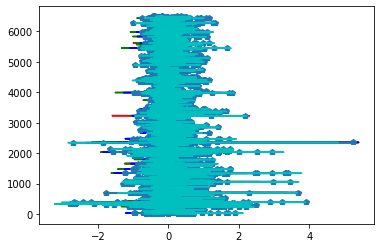

In [28]:
plt.plot(check[:, 0], range(0, len(check)), 'r-', alpha=1)
plt.plot(check[:, 1], range(0, len(check)), 'g-', alpha=1)
plt.plot(check[:, 2], range(0, len(check)), 'b-', alpha=1)
plt.plot(check[:, 3], range(0, len(check)), 'p-', alpha=1)
plt.plot(check[:, 4], range(0, len(check)), 'c-', alpha=1)

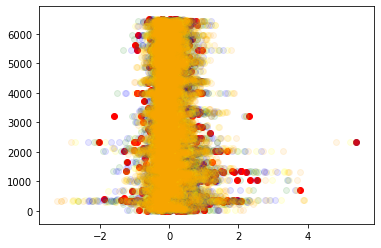

In [29]:
plt.scatter(check[:, 0], range(0, len(check)), c='r', marker='o')
plt.scatter(check[:, 1], range(0, len(check)), c='g', marker='o', alpha=0.1)
plt.scatter(check[:, 2], range(0, len(check)), c='b', marker='o', alpha=0.1)
plt.scatter(check[:, 3], range(0, len(check)), c='yellow', marker='o', alpha=0.1)
plt.scatter(check[:, 4], range(0, len(check)), c='orange', marker='o', alpha=0.1)

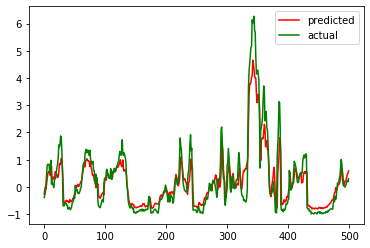

In [30]:
plt.plot(yhat[:500, 0], 'r-', alpha=1, label='predicted')
plt.plot(y_test.reshape(y_test.shape[0], -1)[:500, 0], 'g-', alpha=1, label='actual')
plt.legend()
plt.show()